In [1]:
import pandas as pd
import random
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

%config InlineBackend.figure_format = 'retina'

In [2]:
#git config --global user.email "you@example.com"
#git config --global user.name "Your Name"
#!git fetch origin
#!git merge origin/master

In [3]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1730085023.571059    6776 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730085023.620349    6776 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730085023.622050    6776 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [4]:
# Download the dataset once
if not os.path.exists('fakenet_dataset'):
    !aws s3 cp s3://danylo-ucla/fakenet_dataset.zip ./
    !unzip fakenet_dataset.zip >/dev/null



In [5]:
!tree -L 2 fakenet_dataset

fakenet_dataset
├── score
│   ├── images
│   └── metadata.csv
└── train
    ├── images
    └── metadata.csv

4 directories, 2 files


## Training Images and Metadata

In [6]:
import pandas as pd

# Load the dataset
train_dataset = pd.read_csv('fakenet_dataset/train/metadata.csv')

# Calculate split sizes
train_size = int(0.8 * len(train_dataset))
val_size = int(0.1 * len(train_dataset))

# Split the dataset using slicing
train_metadata = train_dataset.iloc[:train_size]
val_metadata = train_dataset.iloc[train_size:train_size + val_size]
test_metadata = train_dataset.iloc[train_size + val_size:]

# Optional: Print sizes to verify
print(f"Training set size: {len(train_metadata)}")
print(f"Validation set size: {len(val_metadata)}")
print(f"Test set size: {len(test_metadata)}")

Training set size: 9009
Validation set size: 1126
Test set size: 1127


In [7]:
train_metadata.head()

,file_name_training,file_name_generated,caption
0,ffd603965b2eb89bfa6e7bda19c903f9.jpg,d70026e562baeb2976d33ea72bbe2af2.jpg,a toilet with a green and white door and green...
1,c5e15bda1013a6a8c28b87d23aa94767.jpg,41c055de712d74957659ab5d901c4212.jpg,An older couple embracing each other next to a...
2,517547ba7695808a52ecd2e2f4b6faf7.jpg,aab1106eb9793b08b665902c74c8e0cf.jpg,"A square glazed doughnut, and a chocolate doug..."
3,c3ff13909de96ed069fb2769800ea4b9.jpg,0658524e5dc4058fe7ceff0a72dbda18.jpg,A large bathroom with tiled floor and big mirror
4,2b5c6c916a7110287f7193081906cc5e.jpg,8546adea5c43ea5e517abfa5208aa10d.jpg,A man riding a snowboard down a conveyor belt.


In [8]:
val_metadata.head()

,file_name_training,file_name_generated,caption
9009,ec011ab937fca8333d89615bd89b8f31.jpg,1d444b516982550b41e8d1a0bda4a7ba.jpg,A white plate topped with pieces of pizza.
9010,3a9348159edab5d73ae8dff1bf12196f.jpg,14e1a015694c69268b09ee9a9d79d366.jpg,A mirror and other objects stand on a women's ...
9011,c2b27f9bc7c44a213d8d29d1d4c7fcbe.jpg,40c2b9c6761331c55636f6987daee3d4.jpg,a couple of cars parked next to a fire hydran.
9012,36745aef07674e55f3553b04ca8e984d.jpg,a14607644c1aae61532bb85f7ce2e024.jpg,A group of elephants standing under a roof ove...
9013,4cc77acb1e63b247c9db48dd45dd1289.jpg,7c11858cdf7b85b3da759226dbea3254.jpg,Two men standing on a boat in the water.


In [9]:
test_metadata.head()

,file_name_training,file_name_generated,caption
10135,a10a5996c878550ddeb907c9885ad4bb.jpg,422b6c7579380dd686cfc5e442b24e56.jpg,A person in a white jacket skiing down a slope
10136,7ea10250e794e1011feb09b3b5e1f10e.jpg,25b19c6540bb4611dcaf4b4d1083219f.jpg,Lady working in a kitchen while man sits at ta...
10137,fc3bb70cfd4354f34c1ebac4703f39b1.jpg,da384b8612a08a9af4fffb16447808fc.jpg,A man holding a Wii game controller in his hands.
10138,819cfd3698ad82f062dc83f0c0ea694a.jpg,1f2ab9909fc5292078e56b79bcb0e46a.jpg,There is a older man that is riding a horse an...
10139,fd7d5de4b7f3fb86715790e3b990f161.jpg,1fec953b174f2f500a3d5b515ba57a3c.jpg,three gray elephants under a tree in the desert


In [10]:
random.seed(43)

([], [])

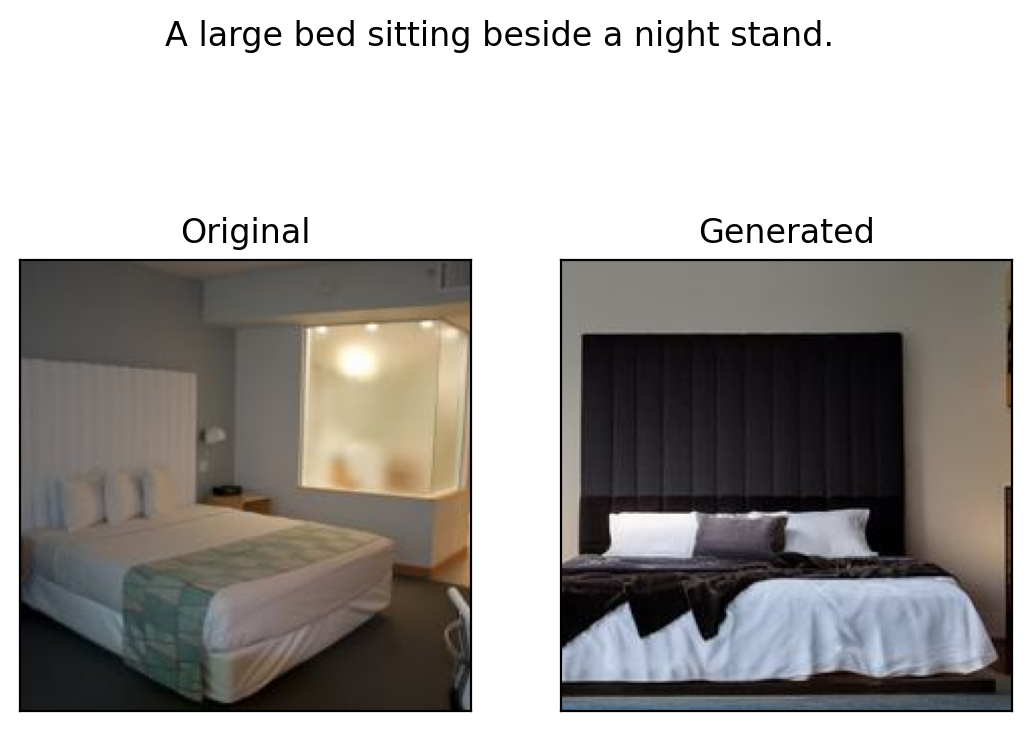

In [11]:
i = random.randint(0, train_metadata.shape[0])

file_name_training = train_metadata['file_name_training'].iloc[i]
file_name_generated = train_metadata['file_name_generated'].iloc[i]
caption = train_metadata['caption'].iloc[i]

plt.suptitle(caption)

plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(Image.open(f'fakenet_dataset/train/images/{file_name_training}'))
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.title('Generated')
plt.imshow(Image.open(f'fakenet_dataset/train/images/{file_name_generated}'))
plt.xticks([])
plt.yticks([])

## Score Images and Metadata

In [12]:
score_metadata = pd.read_csv('fakenet_dataset/score/metadata.csv')
score_metadata

,file_name_a,file_name_b,caption
0,7ad84509c9b0226bc0288537a8ab22ae.jpg,798d20e113a6bde4525336ce66a84a69.jpg,A couple of motorcycles parked next to each ot...
1,a4a39968e428b3c82257e25920e3adeb.jpg,2d6c056b045062c97450a29dd83d8c63.jpg,A vase with a bird on it and a matching winegl...
2,38ffec577b2c097f3a3403ae6c6638b8.jpg,050d2c637cbfa509f9a0072d6ca422b5.jpg,a man that is surfing on some water
3,07ecbbbc269ba1bd2d5b792f9abea0ed.jpg,23cbc59d33f061d2930f27c641a01807.jpg,A crowd of young people sanding on a snow cove...
4,10c585ad69ed895ac1a3b58d5dfb256a.jpg,7bbe5ae59f098437099f5ba093c2b38b.jpg,"A kitchen with a refrigerator, counter and was..."
...,...,...,...
2811,1541d399a4be2e0c85ef061e6bddb60c.jpg,15e819f3f3ede6e2e20170d71185031d.jpg,a close up of a person wearing a suit and tie
2812,d1bc62f2b725409f46421219f16383df.jpg,06f2ad1c20ed610523d677e3cbb8fed6.jpg,Zebras eat from a trough set up in their zoo e...
2813,7015aa30ddb1d1605c6822d2856e98db.jpg,846bd374ab91c40386fa48c1f5fdef78.jpg,A group of people on a field with a Frisbee.
2814,3b76a717ad707699851465a0680f5798.jpg,f5a5c27c396aae7142805befc710f9ac.jpg,A boy sitting at a table eating food with food...


## Tensorflow Dataset (Paired Images, Labeled Segment)

In [13]:
#See Tensorflow Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset

#combine train dataset 2 images, output and make it streamable
from collegium.m04_gan.fakenet_dataset import build_dataset_labeled_paired

train_paired_dataset = build_dataset_labeled_paired(train_metadata).batch(16)
(model_input_a, model_input_b), model_output = next(iter(train_paired_dataset))
display(model_input_a.shape, model_input_b.shape, model_output.shape)

I0000 00:00:1730085026.252363    6776 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730085026.254606    6776 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730085026.256181    6776 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730085026.437564    6776 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

TensorShape([16, 224, 224, 3])

TensorShape([16, 224, 224, 3])

TensorShape([16, 1])

In [14]:
#display(model_input_a)
#display(model_output)
display(caption)

'A large bed sitting beside a night stand.'

In [15]:
#See Tensorflow Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset

#combine train dataset 2 images, output and make it streamable
from collegium.m04_gan.fakenet_dataset import build_dataset_labeled_paired

val_paired_dataset = build_dataset_labeled_paired(val_metadata).batch(16)
(model_input_a, model_input_b), model_output = next(iter(val_paired_dataset))
display(model_input_a.shape, model_input_b.shape, model_output.shape)

TensorShape([16, 224, 224, 3])

TensorShape([16, 224, 224, 3])

TensorShape([16, 1])

In [16]:
#See Tensorflow Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset

#combine train dataset 2 images, output and make it streamable
from collegium.m04_gan.fakenet_dataset import build_dataset_labeled_paired

test_paired_dataset = build_dataset_labeled_paired(test_metadata).batch(16)
(model_input_a, model_input_b), model_output = next(iter(test_paired_dataset))
display(model_input_a.shape, model_input_b.shape, model_output.shape)

TensorShape([16, 224, 224, 3])

TensorShape([16, 224, 224, 3])

TensorShape([16, 1])

In [17]:

#combine score dataset 2 images and make it streamable
from collegium.m04_gan.fakenet_dataset import build_dataset_score_paired

score_paired_dataset = build_dataset_score_paired().batch(16)
((model_input_a, model_input_b),) = next(iter(score_paired_dataset))
display(model_input_a.shape, model_input_b.shape)

TensorShape([16, 224, 224, 3])

TensorShape([16, 224, 224, 3])

In [18]:
####MODEL TRAINING
####MODEL TRAINING
####MODEL TRAINING

In [19]:
# See Keras Functional API
# https://keras.io/guides/functional_api/
import keras
import keras_cv
# https://keras.io/api/keras_cv/models/backbones/efficientnetv2/#frompreset-method
'''backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    "efficientnetv2_b0", #two options: efficientnetv2_b0: base and efficientnetv2_b0_imagenet: base trained on imagenetdataset; 
    input_shape=(224, 224, 3)
)'''

backbone = keras_cv.models.MobileNetV3Backbone.from_preset(
    "mobilenet_v3_large_imagenet", #two options: mobilenet_v3_large: base and mobilenet_v3_large_imagenet: base trained on imagenetdataset;
    input_shape=(224, 224, 3)
)
# Freezes the parameters of the MobileNet layers, so they will not update during training.
# These parameters are initialized to a pre-trained snapshot using the ImagetNet dataset.
backbone.trainable = False

#input shape
inputs = [
    tf.keras.layers.Input((224, 224, 3)),
    tf.keras.layers.Input((224, 224, 3)),
#    tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')  # Text caption
    #tf.keras.layers.Input(shape=(), dtype=tf.string)#, name='text')  # Text caption
]

 
outputs = [
    backbone(inputs[0]),
    backbone(inputs[1]),
]

outputs = tf.keras.layers.Concatenate(axis=-1)(outputs)
# Add BatchNormalization after concatenation
outputs = keras.layers.BatchNormalization()(outputs)
outputs = tf.keras.layers.GlobalAveragePooling2D()(outputs)
#outputs = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(outputs)
#outputs = tf.keras.layers.Flatten()(outputs)
#outputs = tf.keras.layers.Dense(2)(outputs)
outputs = keras.layers.Dropout(0.3)(outputs)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(outputs)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobile_net_v3_larg… │ (None, 7, 7, 960) │  2,996,352 │ input_layer_1[0]… │
│ (MobileNetV3Backbo… │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7,      │          0 │ mobile_net_v3_la… │
│ (Concatenate)       │ 1920)             │            │ mobile_net_v3_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 7, 7,      │      7,680 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 1920)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1920)      │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1920)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      1,921 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,005,953 (11.47 MB)

 Trainable params: 5,761 (22.50 KB)

 Non-trainable params: 3,000,192 (11.44 MB)

In [20]:
'''!pip install pydot
!pip show pydot
!pip install graphviz


#print(pydot_installed, graphviz_installed)  # Both should return True
import pydot, graphviz
plot = tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    dpi=100,
)
#!rm model.png
plot'''

'!pip install pydot\n!pip show pydot\n!pip install graphviz\n\n\n#print(pydot_installed, graphviz_installed)  # Both should return True\nimport pydot, graphviz\nplot = tf.keras.utils.plot_model(\n    model,\n    show_shapes=True,\n    dpi=100,\n)\n#!rm model.png\nplot'

In [21]:
import mlflow
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
def build_model(learning_rate_log: float) -> tf.keras.Model: #encoder_width: int,
    #mlflow.log_param('encoder_width', encoder_width)
    mlflow.log_param('learning_rate_log', learning_rate_log)

    #model.compile('sgd', 'binary_crossentropy')

    # Using binary cross entropy as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    model.compile(
        optimizer=optimizers.Adam(
            learning_rate=float(10 ** learning_rate_log),
        ),
        loss='binary_crossentropy',
        metrics=[
        'accuracy',
    ]
    )
    return model

In [22]:
import json
import uuid
import os

# This function will be used to save each trained model.
def save_model(model: tf.keras.Model, model_path: str):
    os.makedirs(model_path, exist_ok=True)
    tf.keras.models.save_model(model, f'{model_path}/model.keras')
    with open(f'{model_path}/architecture.json', 'w') as f:
        f.write(json.dumps(json.loads(model.to_json()), indent=True))


# This function can be used to load a previously trained model.
def load_model(model_path: str) -> tf.keras.Model:
    return tf.keras.models.load_model(f'{model_path}/model.keras')

In [187]:
# IMPORTANT: This is an example of a reconstruction training mode.
# Your autoencoder has to be trained in denoising mode.
# In other words, you will probably need to tweak these lines of code.
from collegium.foundation.callbacks import MlflowCallback
import tempfile

#model.fit(train_paired_dataset)
#

def train_model(model: tf.keras.Model, epochs: int, verbose: int = 10) -> tf.keras.callbacks.History:
    history = model.fit(
        train_paired_dataset,

        # It's a good idea to have low number of epochs,
        # to test the learning process, but not for the final model training.
        epochs=epochs,

        batch_size=32,
        shuffle=True,
        validation_data=val_paired_dataset,#(validate_anomaly_X, validate_anomaly_X),
        callbacks=[MlflowCallback()],
        verbose=2
    )

    # Save model parameters to the file system and upload to MLFlow.
    with tempfile.TemporaryDirectory('wb') as d:
        model_path = f'{d}/model'
        save_model(model, model_path)
        mlflow.log_artifacts(d)

    return history

In [24]:

# See MLFlow docs for more API examples.
# https://mlflow.org/docs/latest/python_api/mlflow.html

import mlflow
expt_name = 'fakenet_GAN_test_05_GAP_mobile_LR5'
mlflow.set_experiment(expt_name)
# mlflow.tensorflow.autolog(log_models=False, log_input_examples=False, log_model_signatures=False, silent=True)
mlflow.get_experiment_by_name(expt_name)

2024/10/27 20:11:44 INFO mlflow.tracking.fluent: Experiment with name 'fakenet_GAN_test_05_GAP_mobile_LR5' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///app/mlflow/927951947173411480', creation_time=1730085105006, experiment_id='927951947173411480', last_update_time=1730085105006, lifecycle_stage='active', name='fakenet_GAN_test_05_GAP_mobile_LR5', tags={}>

In [125]:
# In order to have reproducible results, we need
# to set the seed values for NumPy and Tensorflow.
# Keep these lines in the same cell as the training code,
# so that you don't accidentally train multiples models
# without reseting the seed.

import numpy as np
import tensorflow as tf

np.random.seed(11)
tf.random.set_seed(11)

with mlflow.start_run()
    model = build_model(learning_rate_log=-2)
    history = train_model(model, epochs=2)

Epoch 1/2


/app/conda/envs/collegium/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1484', 'keras_tensor_1485']. Received: the structure of inputs=('*', '*')
  warnings.warn(


564/564 - 79s - 141ms/step - accuracy: 0.7888 - loss: 0.6903 - val_accuracy: 0.8188 - val_loss: 0.5923
Epoch 2/2
564/564 - 50s - 88ms/step - accuracy: 0.8096 - loss: 0.6226 - val_accuracy: 0.8561 - val_loss: 0.3693


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


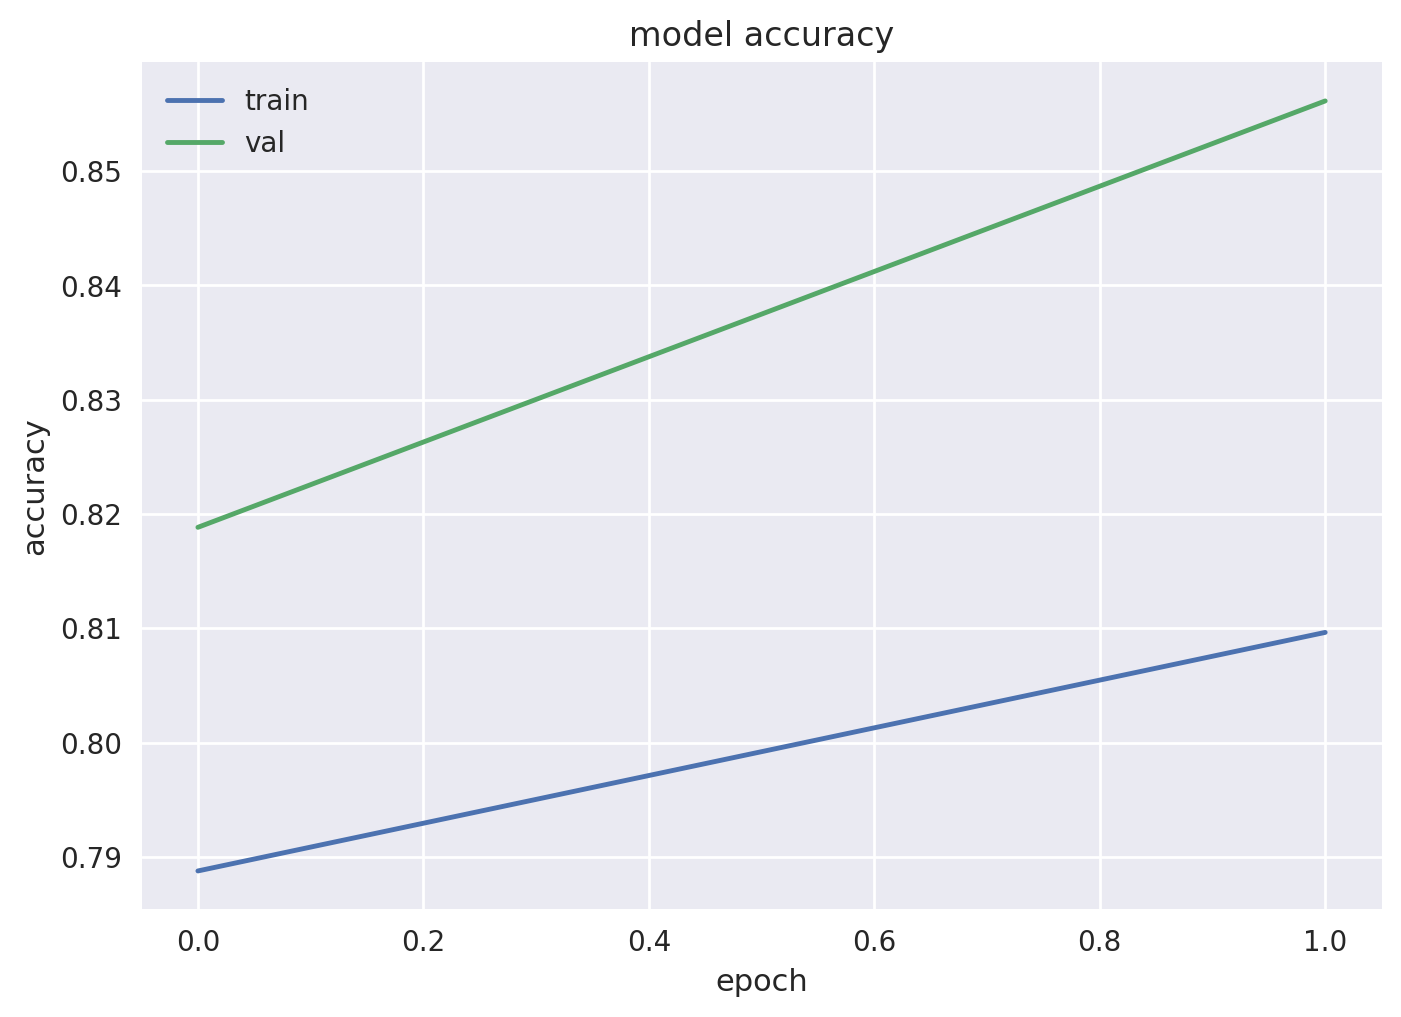

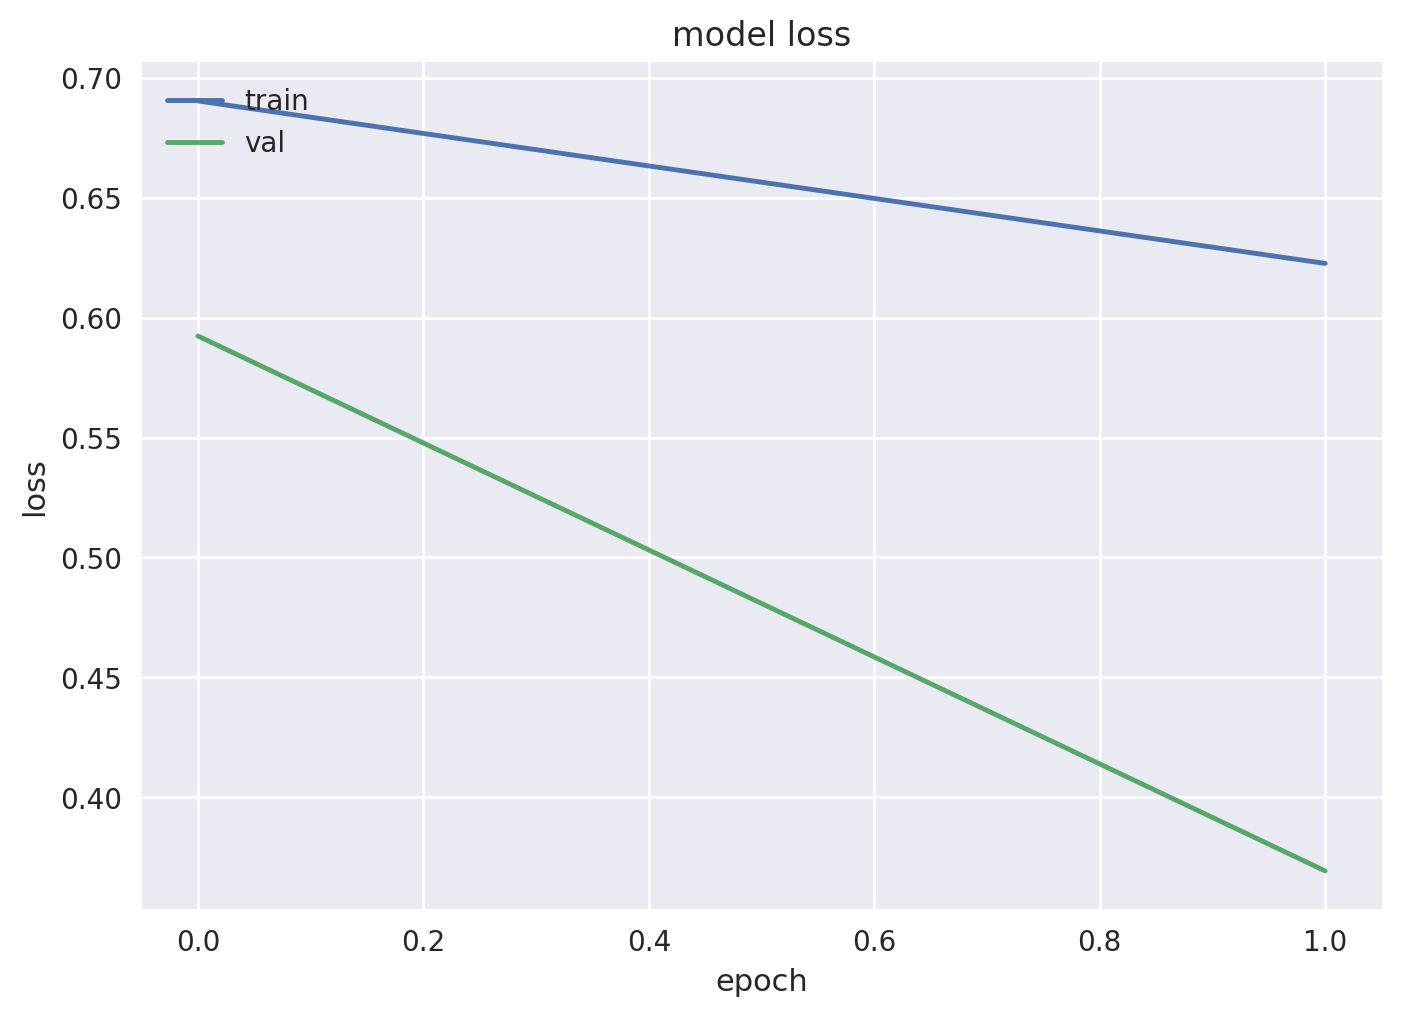

In [126]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [62]:
#client = MlflowClient()

In [81]:
# Start MLflow UI on default port 5000
!mlflow ui

# Or if port 5000 is busy, specify a different port
#!mlflow ui --port 5001

# Alternative command
!mlflow server --port 5000

[2024-10-27 18:57:30 -0700] [2951] [INFO] Starting gunicorn 23.0.0
[2024-10-27 18:57:30 -0700] [2951] [INFO] Listening at: http://127.0.0.1:5000 (2951)
[2024-10-27 18:57:30 -0700] [2951] [INFO] Using worker: sync
[2024-10-27 18:57:30 -0700] [2952] [INFO] Booting worker with pid: 2952
[2024-10-27 18:57:30 -0700] [2953] [INFO] Booting worker with pid: 2953
[2024-10-27 18:57:30 -0700] [2954] [INFO] Booting worker with pid: 2954
[2024-10-27 18:57:30 -0700] [2955] [INFO] Booting worker with pid: 2955



KeyboardInterrupt



In [48]:
# This loads the last active run,
# but you probably want to load the best run from the experiment.
last_run = mlflow.last_active_run()
saved_model_path = mlflow.tracking.MlflowClient().download_artifacts(last_run.info.run_id, 'model')
#model = load_model(saved_model_path)

OSError: No such file or directory: '/app/mlflow/248153822285736116/3fdb6030075d40b08954e1f7f8175f69/artifacts/model'

In [25]:
%%time

from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

# IMPORTANT: In order to pass the assignment, you need
# to improve the architecture and/or training procedure of this model.
# You CAN NOT submit the model as is. Please add plain English Python
# comments on how you modified the model and/or training procedure.
np.random.seed(11)
tf.random.set_seed(11)
model = build_model(learning_rate_log=-3)
history = model.fit(
    train_paired_dataset,

    validation_data=val_paired_dataset,
    epochs=50,
    batch_size=32,
    callbacks=[
        TerminateOnNaN(),
        ReduceLROnPlateau(
            monitor='loss',
            min_delta=0.1,
            patience=5,
            factor=0.1,
            cooldown=10,
            verbose=1
        ),
        EarlyStopping(
            monitor='loss',
            min_delta=0.1,
            patience=10
        )
    ]
)

Epoch 1/50


/app/conda/envs/collegium/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_215', 'keras_tensor_216']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1730085126.103691    6895 service.cc:146] XLA service 0x7fd788111af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730085126.103715    6895 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5


      3/Unknown 18s 62ms/step - accuracy: 0.4271 - loss: 1.0283

I0000 00:00:1730085134.566522    6895 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    564/Unknown 84s 117ms/step - accuracy: 0.7055 - loss: 0.5570

/app/conda/envs/collegium/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


564/564 ━━━━━━━━━━━━━━━━━━━━ 101s 147ms/step - accuracy: 0.7056 - loss: 0.5568 - val_accuracy: 0.8730 - val_loss: 0.3016 - learning_rate: 0.0010
Epoch 2/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 65s 115ms/step - accuracy: 0.8436 - loss: 0.3562 - val_accuracy: 0.8952 - val_loss: 0.2666 - learning_rate: 0.0010
Epoch 3/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 65s 116ms/step - accuracy: 0.8494 - loss: 0.3367 - val_accuracy: 0.8970 - val_loss: 0.2631 - learning_rate: 0.0010
Epoch 4/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 64s 114ms/step - accuracy: 0.8601 - loss: 0.3284 - val_accuracy: 0.9067 - val_loss: 0.2624 - learning_rate: 0.0010
Epoch 5/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 64s 114ms/step - accuracy: 0.8612 - loss: 0.3236 - val_accuracy: 0.8837 - val_loss: 0.2649 - learning_rate: 0.0010
Epoch 6/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 64s 114ms/step - accuracy: 0.8558 - loss: 0.3359 - val_accuracy: 0.8952 - val_loss: 0.2644 - learning_rate: 0.0010
Epoch 7/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 64s 114ms/step - accuracy: 0.8576 - loss

71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.8956 - loss: 0.2467
Test Loss: 0.2487
Test Accuracy: 0.8980
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step


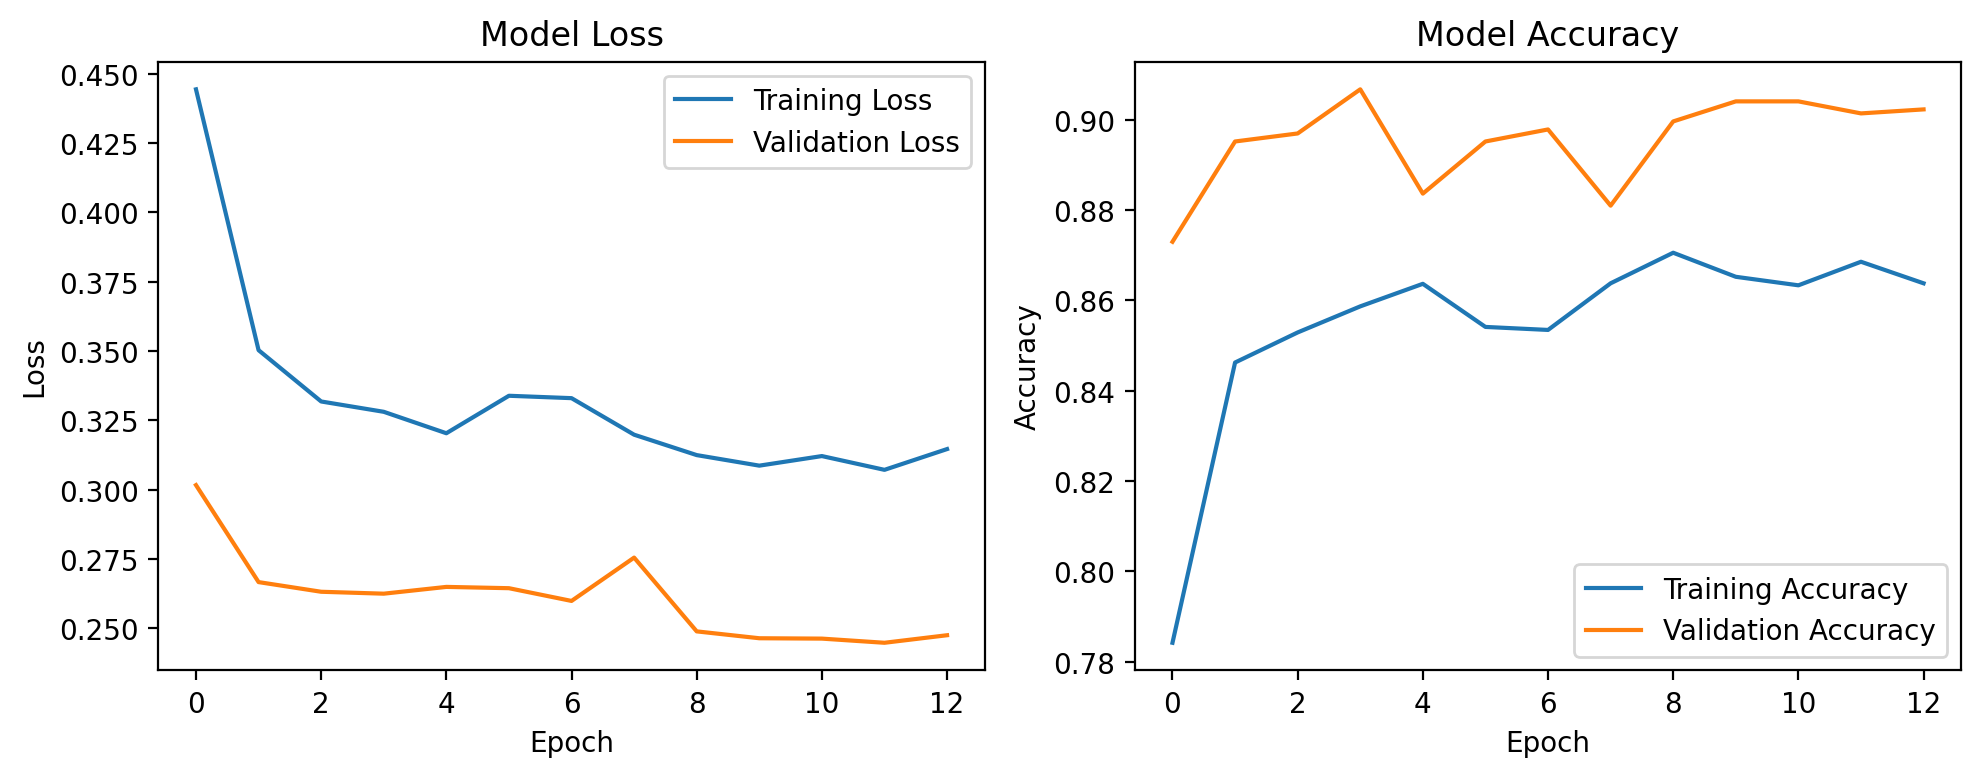

In [30]:
#test_y_hat = model.predict(test_paired_dataset)

# Evaluate model on test dataset
test_loss, test_accuracy = model.evaluate(test_paired_dataset)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# If you want to get predictions as well
test_predictions = model.predict(test_paired_dataset)

# To visualize training history
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# The expected model output for the score segment is a DataFrame with 1 column -- 'probability'.
# One probability per row in the score metadata.
# The probability represents the likelihood that the image in the 'file_name_a' column is real.

# The following code can be used to check the DataFrame in 'score_y_hat':
score_y_hat = model.predict(score_paired_dataset)
score_y_hat = pd.DataFrame(score_y_hat, columns=['probability'])
assert score_y_hat.shape == (score_metadata.shape[0], 1)
assert score_y_hat.probability.dtype == np.float32
assert score_y_hat.probability.min() >= 0
assert score_y_hat.probability.max() <= 1

/app/conda/envs/collegium/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_215', 'keras_tensor_216']. Received: the structure of inputs=('*', '*')
  warnings.warn(


176/176 ━━━━━━━━━━━━━━━━━━━━ 42s 204ms/step


/app/conda/envs/collegium/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [27]:
# Once you are satisfied with your model,
# your need to submit 4 files:
# 1. this notebook and/or any other Python scripts
# 2. Model definition in JSON format
# 3. Model parameters in H5 format
# 4. the probabilities for the score segment

import os
model_dir = 'fakenet_model'
os.makedirs(model_dir, exist_ok=True)

# Save model definition:
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    model_json = json.dumps(json.loads(model.to_json()), indent=True)
    f.write(model_json)

# Save the learned parameters.
model.save_weights(f"{model_dir}/keras_parameters.weights.h5")

# Finally, let's save the forecast.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')